In [4]:
import os
import os.path as op

# Remove any preset backend
os.environ.pop("MPLBACKEND", None)

import matplotlib
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from neuromaps import transforms
from matplotlib.gridspec import GridSpec
import pandas as pd
from gradec.utils import _zero_medial_wall
import nibabel as nib
from nilearn import datasets
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps
from surfplot import Plot
from nilearn import datasets
from gradec.plot import plot_radar, plot_cloud
from gradec.fetcher import _fetch_features, _fetch_frequencies, _fetch_classification
from gradec.utils import _decoding_filter
from nimare.decode.continuous import CorrelationDecoder
import numpy as np
from nilearn.maskers import NiftiMasker
from nilearn.image import threshold_img, index_img
from neuromaps.datasets import fetch_fslr
from nimare.transforms import p_to_z
from nilearn.plotting import plot_stat_map
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import nilearn.reporting

from nilearn import datasets, plotting, image

In [5]:
CMAP = nilearn_cmaps["cold_hot"]
CMAP = "Spectral_r"

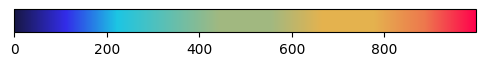

In [6]:
# Define the number of colors in the colormap
num_colors = 1000

# Define anchor points for key colors using hex values
colors = [
    "#171744",  # Dark Blue
    "#322ce8",
    "#1cc5e3",  # light blue
    "#5fbfb1",
    "#a1b880",
    "#a1b880",
    "#E4B24E",  # Yellow (adjusted)
    "#E4B24E",  # Yellow (adjusted)
    "#ed774d",  # Orange
    # "#f63b4d",  # Orange
    "#ff004c",  # Red
]
# Create a smooth interpolation for the custom colormap
CMAP = LinearSegmentedColormap.from_list("custom_cmap", colors, N=num_colors)

# Plot the color gradient
plt.figure(figsize=(8, 2))
plt.imshow([list(range(num_colors))], aspect="auto", cmap=CMAP)
plt.gca().set_visible(False)
plt.colorbar(orientation="horizontal")
plt.show()

In [7]:
def trim_image(img=None, tol=1, fix=True):
    if fix:
        mask = img != tol
    else:
        mask = img <= tol
    if img.ndim == 3:
        mask = mask.any(2)
    mask0, mask1 = mask.any(0), mask.any(1)
    return img[np.ix_(mask1, mask0)]

In [8]:
def plot_vol(
    nii_img_thr, threshold, mask_contours=None, vmax=6, alpha=1, cmap=CMAP, dim=-0.45
):
    template = datasets.load_mni152_template(resolution=1)

    display_modes = ["x", "y", "z"]
    fig = plt.figure(figsize=(5, 5))
    fig.subplots_adjust(
        left=None, bottom=None, right=None, top=None, wspace=None, hspace=None
    )
    gs = GridSpec(2, 2, figure=fig)

    for dsp_i, display_mode in enumerate(display_modes):
        if display_mode == "z":
            ax = fig.add_subplot(gs[:, 1], aspect="equal")
            colorbar = True
        else:
            ax = fig.add_subplot(gs[dsp_i, 0], aspect="equal")
            colorbar = False

        display = plot_stat_map(
            nii_img_thr,
            bg_img=template,
            black_bg=False,
            draw_cross=False,
            annotate=True,
            alpha=alpha,
            cmap=cmap,
            threshold=threshold,
            colorbar=colorbar,
            display_mode=display_mode,
            cut_coords=1,
            vmax=vmax,
            axes=ax,
            dim=dim,  # Adjusted dimming factor
        )
        if mask_contours:
            display.add_contours(mask_contours, levels=[0.5], colors="black")

    return fig

In [9]:
def plot_surf(nii_img_thr, mask_contours=None, vmax=8, cmap=CMAP):
    map_lh, map_rh = transforms.mni152_to_fslr(nii_img_thr, fslr_density="32k")
    map_lh, map_rh = _zero_medial_wall(
        map_lh,
        map_rh,
        space="fsLR",
        density="32k",
    )
    # midthickness

    surfaces = fetch_fslr(density="32k")
    lh, rh = surfaces["inflated"]
    sulc_lh, sulc_rh = surfaces["sulc"]

    p = Plot(surf_lh=lh, surf_rh=rh, layout="grid")
    p.add_layer({"left": sulc_lh, "right": sulc_rh}, cmap="binary_r", cbar=False)
    p.add_layer(
        {"left": map_lh, "right": map_rh},
        cmap=cmap,
        cbar=False,
        color_range=(-vmax, vmax),
    )
    if mask_contours:
        mask_lh, mask_rh = transforms.mni152_to_fslr(mask_contours, fslr_density="32k")
        mask_lh, mask_rh = _zero_medial_wall(
            mask_lh,
            mask_rh,
            space="fsLR",
            density="32k",
        )
        mask_arr_lh = mask_lh.agg_data()
        mask_arr_rh = mask_rh.agg_data()
        countours_lh = np.zeros_like(mask_arr_lh)
        countours_lh[mask_arr_lh != 0] = 1
        countours_rh = np.zeros_like(mask_arr_rh)
        countours_rh[mask_arr_rh != 0] = 1

        colors = [(0, 0, 0, 0)]
        contour_cmap = ListedColormap(colors, "regions", N=1)
        line_cmap = ListedColormap(["black"], "regions", N=1)
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=line_cmap,
            as_outline=True,
            cbar=False,
        )
        p.add_layer(
            {"left": countours_lh, "right": countours_rh},
            cmap=contour_cmap,
            cbar=False,
        )

    return p.build()

In [10]:
data_dir = "./dset"
out_dir = "./derivatives"

In [11]:
DSET, MODEL = "neuroquery", "lda"
decoding_dir = "./decoding"
decoder_fn = op.join(data_dir, f"{MODEL}_{DSET}_decoder.pkl.gz")

decoder = CorrelationDecoder.load(decoder_fn)

features = _fetch_features(DSET, MODEL, data_dir=decoding_dir)
frequencies = _fetch_frequencies(DSET, MODEL, data_dir=decoding_dir)
classification, class_lst = _fetch_classification(DSET, MODEL, data_dir=decoding_dir)

In [12]:
mask_img = datasets.load_mni152_brain_mask(resolution=1)
masker = NiftiMasker(mask_img=mask_img)
masker = masker.fit()

In [13]:
test_dict = {
    "1s": "Group Average (One-Sample T-Test)",
    "2s": "Group Comparison (Two-Sample Unpaired T-Test: ASD-TD)",
}

In [14]:
# Setup directories and file paths
group_dir = op.join(data_dir, "group/habenula_mni_dilated")
group_avg_dir = op.join(out_dir, "group-averaged")
group_diff_dir = op.join(out_dir, "group-difference")

# File paths
brik_fn = op.join(
    group_dir, "sub-group_task-rest_desc-1S2StTesthabenula_briks+tlrc.BRIK"
)
table_fn = op.join(group_dir, "sub-group_task-rest_desc-1S2StTesthabenula_table.txt")
nii_1s_fn = op.join(
    group_avg_dir, "sub-group_task-rest_desc-1SampletTest.nii.gz"
)
nii_2s_fn = op.join(
    group_diff_dir, "sub-group_task-rest_desc-2SampletTest.nii.gz"
)
cluster_fn = op.join(
    data_dir, "clustsim", "clustsim_out.NN2_2sided.1D"
)

# Load cluster correction table
column_names = [".10000", ".05000", ".02000", ".01000"]
cluster_df = pd.read_table(cluster_fn, skiprows=8, delim_whitespace=True, names=column_names)
cluster_df = cluster_df.reset_index()
cluster_df.rename(columns={'index': 'pthr'}, inplace=True)
print("Cluster correction table:")
print(cluster_df)

# Analysis parameters
brik_idx = [8, 10]
nii_fns = [nii_1s_fn, nii_2s_fn]
tests = ["1s", "2s"]
alpha = ".01000"
pthrs = [0.0001, 0.0001]
cohen_thresh = 0

# Load participant data for effect size calculations
data_df = pd.read_csv(table_fn, sep="\t")
n_sub = data_df.groupby("group").size().sum()
n_sub_1, n_sub_2 = data_df.groupby("group").size().values
print(f"Total subjects: {n_sub}, Group sizes: {n_sub_1}, {n_sub_2}")

Cluster correction table:
     pthr  .10000  .05000  .02000  .01000
0  0.0500  1482.6  1773.0  2163.0  2497.0
1  0.0200   518.3   623.0   768.0   880.0
2  0.0100   283.8   343.1   423.0   489.5
3  0.0050   168.3   205.7   254.7   298.3
4  0.0020    93.8   113.8   141.8   168.5
5  0.0010    62.3    76.7    97.0   116.7
6  0.0005    43.1    53.9    67.7    79.7
7  0.0002    27.0    33.7    44.0    53.0
8  0.0001    18.9    24.4    31.8    38.8
Total subjects: 1584, Group sizes: 705, 879


/var/folders/b0/6xxmhnys7hj9g_47_dsjm7c00000gn/T/ipykernel_6164/1091506867.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cluster_df = pd.read_table(cluster_fn, skiprows=8, delim_whitespace=True, names=column_names)



=== Processing Group Average (One-Sample T-Test) ===
File ./derivatives/group-averaged/sub-group_task-rest_desc-1SampletTest.nii.gz already exists, skipping conversion.
Cluster extent: 38.8, p-threshold: 0.0001, z-threshold: 3.890591886413094
Cluster extent: 38.8, p-threshold: 0.0001, z-threshold: 3.890591886413094


/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You mig

Significant clusters:
   Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0           1  -0.5 -28.5   1.5  38.277458             645336
1          1a   5.5  -2.5   1.5  17.070114                   
2          1b  13.5 -30.5  -4.5  15.703444                   
3          1c  -0.5 -22.5 -18.5  14.814359                   
4           2 -28.5  33.5  25.5   6.612488               3728
5          2a -24.5  23.5  41.5   5.389577                   
6          2b -32.5  39.5  33.5   5.230610                   
7          2c -28.5  35.5  39.5   5.091123                   
8           3  25.5  31.5  39.5   6.094035               3536
9          3a  31.5  37.5  25.5   5.589732                   
10         3b  21.5  31.5  45.5   5.528059                   
11         3c  37.5  31.5  31.5   5.076546                   
12          4 -32.5 -56.5  43.5   6.044006                936
13          5 -20.5 -44.5  71.5   5.870116                488
14         5a -26.5 -42.5  65.5   4.163960      

/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Saved figures to ./derivatives/group-averaged

=== Processing Group Comparison (Two-Sample Unpaired T-Test: ASD-TD) ===
File ./derivatives/group-difference/sub-group_task-rest_desc-2SampletTest.nii.gz already exists, skipping conversion.
Cluster extent: 38.8, p-threshold: 0.0001, z-threshold: 3.890591886413094


/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You mig

Significant clusters:
  Cluster ID     X     Y     Z  Peak Stat Cluster Size (mm3)
0          1  59.5 -38.5  -0.5   5.402785               1256
1         1a  47.5 -40.5   3.5   4.879167                   
2         1b  69.5 -38.5  -0.5   4.619359                   
3          2 -52.5 -24.5  -2.5   4.930276               1160
4         2a -60.5 -28.5   3.5   4.642123                   
5         2b -60.5 -30.5  -4.5   4.306325                   
6          3 -60.5 -12.5  35.5   4.861617                480
Saved thresholded nifti: ./derivatives/group-difference/sub-group_task-rest_desc-2SampletTest_thresh.nii.gz
Generating visualizations...


/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/Users/chloehampson/Desktop/habenula-abide-rsfc/.venv/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


Saved figures to ./derivatives/group-difference


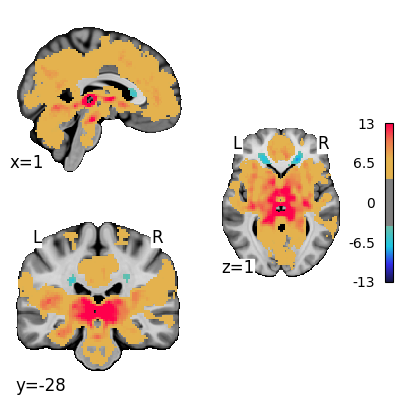

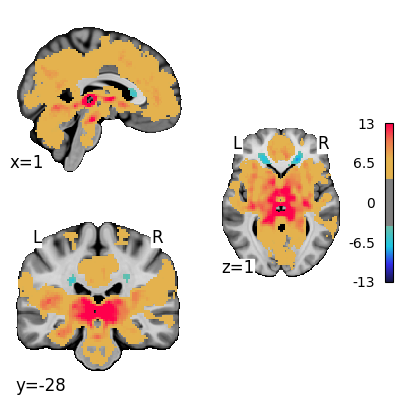

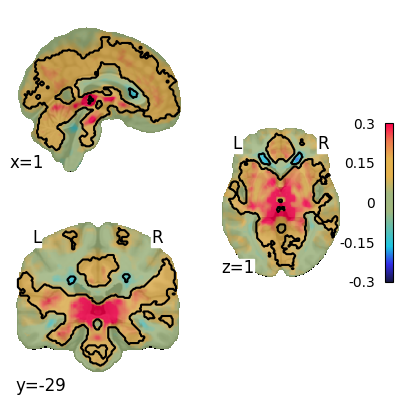

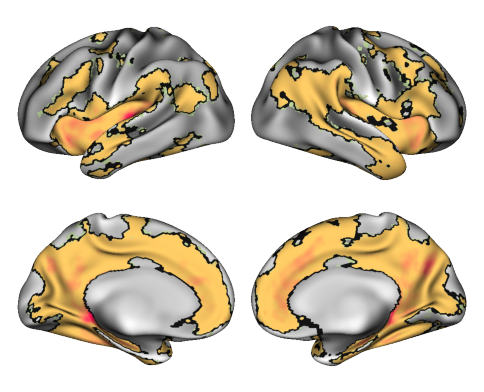

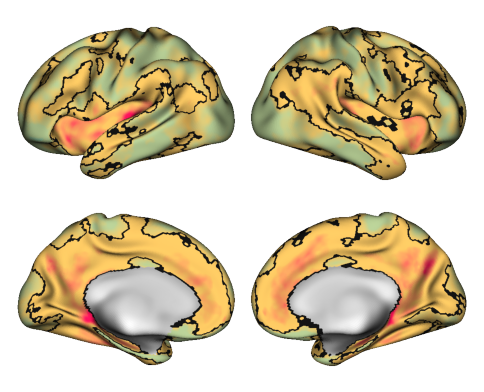

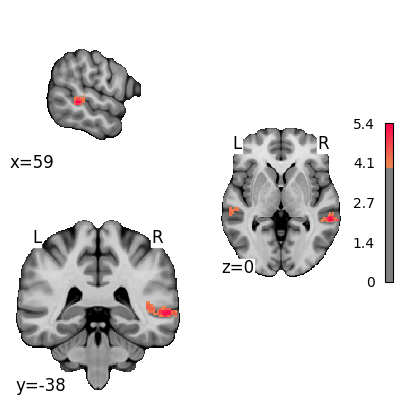

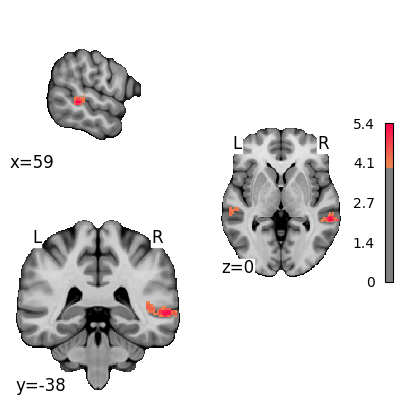

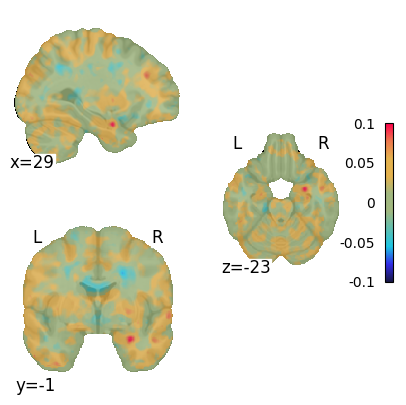

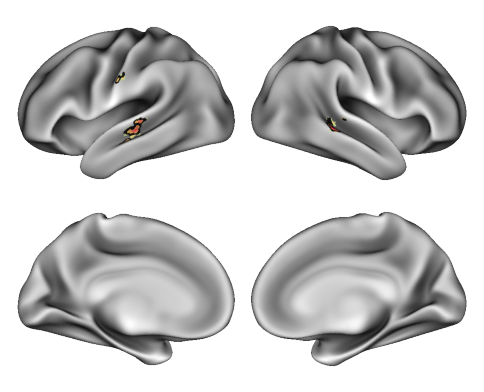

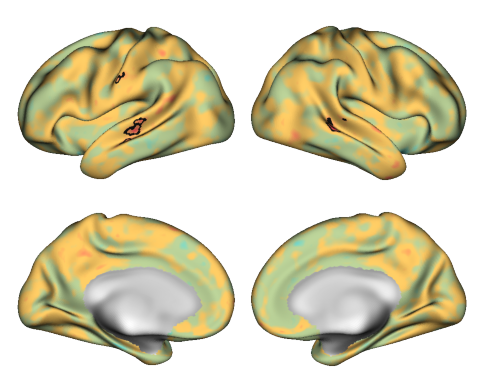

In [15]:
# Process each test type (1-sample and 2-sample)
for brik_i, nii_fn, test, pthr in zip(brik_idx, nii_fns, tests, pthrs):
    print(f"\n=== Processing {test_dict[test]} ===")
    
    # Check if the output file already exists
    if not os.path.exists(nii_fn):
        print(f"Creating {nii_fn}...")
        if test == "1s":
            convert = f"3dAFNItoNIFTI \
                -prefix {nii_fn} \
                {brik_fn}[{brik_i}]"
            os.system(convert)
        elif test == "2s":
            convert = f"3dcalc -a {brik_fn}'[{brik_i}]' -expr '-1*a' -prefix {nii_fn}"
            os.system(convert)
    else:
        print(f"File {nii_fn} already exists, skipping conversion.")
    
    # Load and threshold images
    nii_img = nib.load(nii_fn)
    z_thresh = p_to_z(pthr)
    clust_ext = cluster_df.loc[cluster_df["pthr"] == pthr, alpha].values[0]
    nii_thr_img = threshold_img(nii_img, z_thresh, cluster_threshold=clust_ext)
    print(f"Cluster extent: {clust_ext}, p-threshold: {pthr}, z-threshold: {z_thresh}")
    
    # Calculate effect sizes (Cohen's d)
    nii_arr = masker.transform(nii_img)
    if test == "1s":
        nii_cohen_arr = nii_arr / np.sqrt(n_sub)
    elif test == "2s":
        nii_cohen_arr = nii_arr / (np.sqrt(n_sub_1) + np.sqrt(n_sub_2))
    
    nii_cohen_img = masker.inverse_transform(nii_cohen_arr)
    
    # Create contour masks for visualization
    nii_thr_arr = masker.transform(nii_thr_img)
    nii_contour_arr = np.zeros_like(nii_thr_arr)
    nii_contour_arr[(nii_thr_arr > z_thresh) | (nii_thr_arr < -z_thresh)] = 1
    nii_contour_img = masker.inverse_transform(nii_contour_arr)
    nii_contour_img_3d = index_img(nii_contour_img, 0)
    
    # Set visualization parameters
    vmax = round(np.max(np.abs(nii_thr_arr)), 2)
    vmax = 13 if vmax > 13 else vmax
    c_vmax = 0.1 if test == "2s" else 0.3
    
    # Generate cluster table and save thresholded images
    clusters = nilearn.reporting.get_clusters_table(
        nii_thr_img, z_thresh, two_sided=True
    )
    print("Significant clusters:")
    print(clusters)
    
    # Save thresholded images to appropriate directories
    if test == "1s":
        thresh_fn = op.join(group_avg_dir, f"sub-group_task-rest_desc-1SampletTest_thresh.nii.gz")
    elif test == "2s":
        thresh_fn = op.join(group_diff_dir, f"sub-group_task-rest_desc-2SampletTest_thresh.nii.gz")
    
    nib.save(nii_thr_img, thresh_fn)
    print(f"Saved thresholded nifti: {thresh_fn}")
    
    # Generate all visualizations
    print("Generating visualizations...")
    
    # First, get coordinates from the thresholded statistical map
    from nilearn.plotting import find_xyz_cut_coords
    coords = find_xyz_cut_coords(nii_thr_img, activation_threshold=z_thresh)
    
    stat_fig = plot_vol(nii_thr_img, z_thresh, vmax=vmax, cmap=CMAP)
    vol_fig = plot_vol(nii_thr_img, z_thresh, vmax=vmax, cmap=CMAP)
    cohen_fig = plot_vol(
        nii_cohen_img,
        cohen_thresh,
        mask_contours=nii_contour_img_3d,
        vmax=c_vmax,
        alpha=0.8,
        cmap=CMAP,
    )
    surf_fig = plot_surf(nii_thr_img, mask_contours=nii_contour_img_3d, vmax=vmax, cmap=CMAP)
    cohen_surf_fig = plot_surf(
        nii_cohen_img, mask_contours=nii_contour_img_3d, vmax=c_vmax, cmap=CMAP
    )
    
    # Prepare data for decoding
    if test == "1s":
        nii_pos_arr = np.where(nii_arr > 0, nii_arr, 0)
        img_to_decode = masker.inverse_transform(nii_pos_arr)
    elif test == "2s":
        nii_neg_arr = abs(np.where(nii_arr > 0, nii_arr, 0))
        img_to_decode = masker.inverse_transform(nii_neg_arr)
    
    # Decode the image
    corrs_df = decoder.transform(img_to_decode)
    num_val = [int(lab.split("__")[1].split("_")[0]) for lab in corrs_df.index.to_list()]
    indices = np.argsort(num_val)
    corrs_df = corrs_df.iloc[indices]
    filtered_df, filtered_features, filtered_frequencies = _decoding_filter(
        corrs_df,
        features,
        classification,
        freq_by_topic=frequencies,
        class_by_topic=class_lst,
    )
    
    # Visualize decoding results
    corrs = filtered_df["r"].to_numpy()
    
    # Save figures to appropriate directories
    if test == "1s":
        fig_save_dir = group_avg_dir
    elif test == "2s":
        fig_save_dir = group_diff_dir
    
    # Radar plot
    plot_radar(
        corrs,
        filtered_features,
        MODEL,
        cmap=CMAP,
        out_fig=op.join(fig_save_dir, f"{test}_radar.png"),
    )
    
    # Word cloud plot
    plot_cloud(
        corrs,
        filtered_features,
        MODEL,
        width=10,
        height=5,
        frequencies=filtered_frequencies,
        cmap=CMAP,
        out_fig=op.join(fig_save_dir, f"{test}_wordcloud.png"),
    )
    
    vol_fig.savefig(op.join(fig_save_dir, f"{test}_volume.png"), bbox_inches="tight", dpi=300)
    cohen_fig.savefig(op.join(fig_save_dir, f"{test}_volume-cohen.png"), bbox_inches="tight", dpi=300)
    surf_fig.savefig(op.join(fig_save_dir, f"{test}_surface.png"), bbox_inches="tight", dpi=300)
    cohen_surf_fig.savefig(op.join(fig_save_dir, f"{test}_surface-cohen.png"), bbox_inches="tight", dpi=300)
    
    print(f"Saved figures to {fig_save_dir}")
    print("="*50)

## Combine sub-figures

Saved combined figure: ./derivatives/group-averaged/combined_1s.png


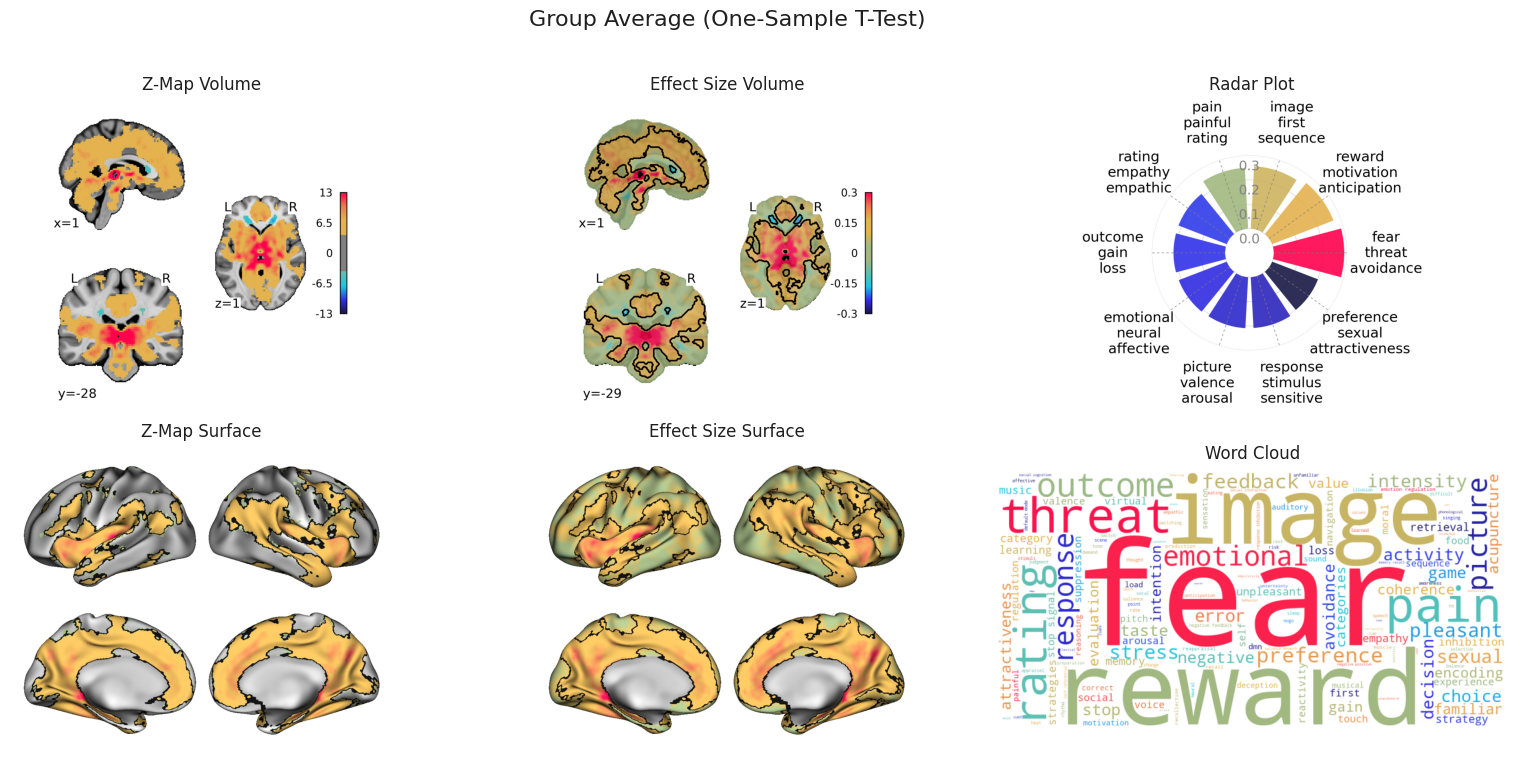

Saved combined figure: ./derivatives/group-difference/combined_2s.png


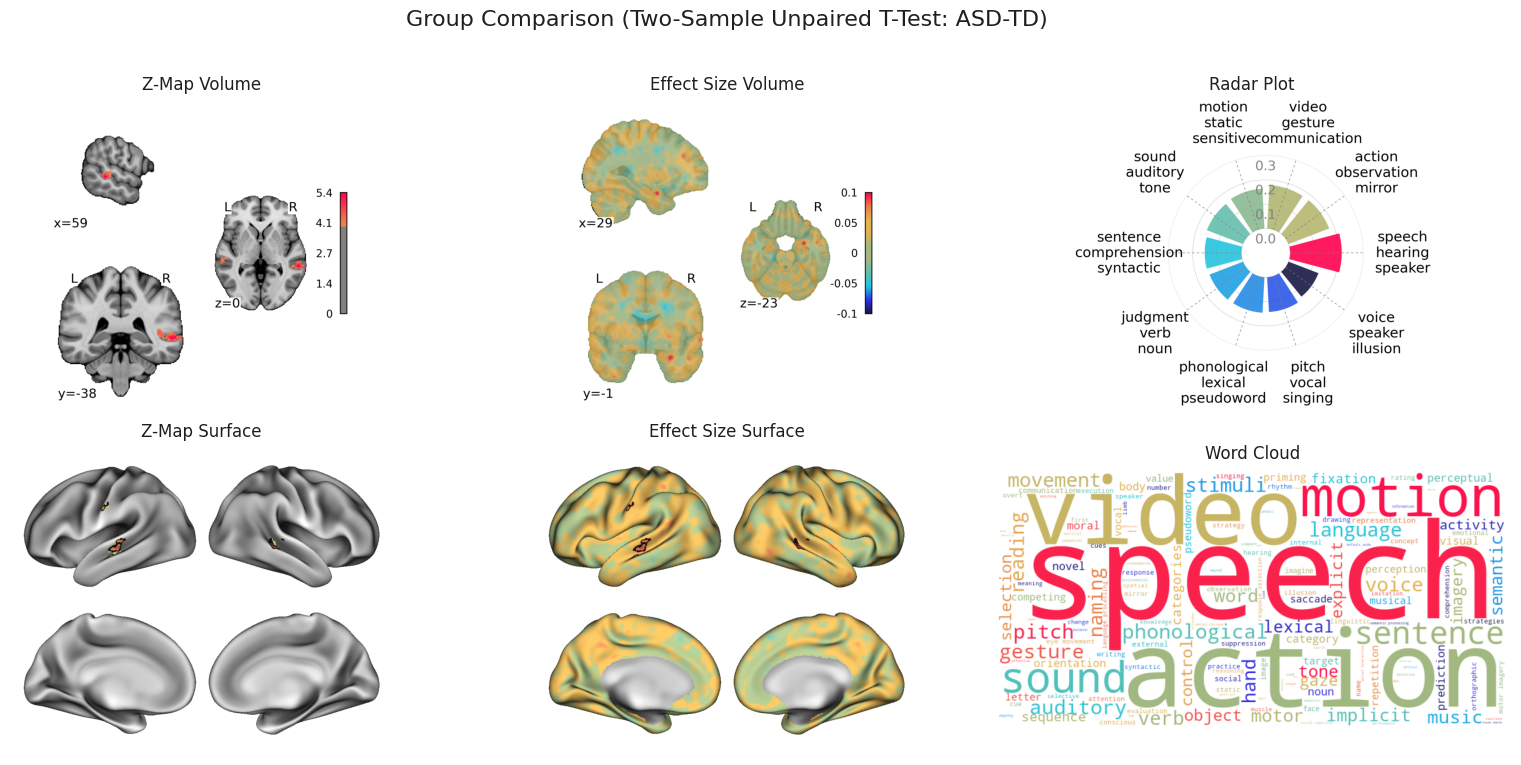

In [16]:
for test in tests:
    # Determine the correct directory for this test
    if test == "1s":
        fig_source_dir = group_avg_dir
    elif test == "2s":
        fig_source_dir = group_diff_dir
    
    output_file = op.join(fig_source_dir, f"combined_{test}.png")

    figure1 = plt.figure(figsize=(16, 8))
    gs = GridSpec(
        nrows=2, ncols=3, figure=figure1, 
        width_ratios=[1, 1, 1], height_ratios=[1, 1]
    )

    # Column 0: Z-Map volume and surface
    vol_fn = op.join(fig_source_dir, f"{test}_volume.png")
    surf_fn = op.join(fig_source_dir, f"{test}_surface.png")
    
    if os.path.exists(vol_fn):
        img = mpimg.imread(vol_fn)
        ax = figure1.add_subplot(gs[0, 0])
        ax.imshow(img)
        ax.set_title("Z-Map Volume", fontsize=12)
        ax.set_axis_off()
    
    if os.path.exists(surf_fn):
        img = mpimg.imread(surf_fn)
        ax = figure1.add_subplot(gs[1, 0])
        ax.imshow(img)
        ax.set_title("Z-Map Surface", fontsize=12)
        ax.set_axis_off()

    # Column 1: Cohen's d volume and surface
    cohen_vol_fn = op.join(fig_source_dir, f"{test}_volume-cohen.png")
    cohen_surf_fn = op.join(fig_source_dir, f"{test}_surface-cohen.png")
    
    if os.path.exists(cohen_vol_fn):
        img = mpimg.imread(cohen_vol_fn)
        ax = figure1.add_subplot(gs[0, 1])
        ax.imshow(img)
        ax.set_title("Effect Size Volume", fontsize=12)
        ax.set_axis_off()
    
    if os.path.exists(cohen_surf_fn):
        img = mpimg.imread(cohen_surf_fn)
        ax = figure1.add_subplot(gs[1, 1])
        ax.imshow(img)
        ax.set_title("Effect Size Surface", fontsize=12)
        ax.set_axis_off()

    # Column 2: Radar plot and word cloud
    radar_fn = op.join(fig_source_dir, f"{test}_radar.png")
    if os.path.exists(radar_fn):
        radar_img = mpimg.imread(radar_fn)
        ax = figure1.add_subplot(gs[0, 2])
        ax.imshow(radar_img)
        ax.set_title("Radar Plot", fontsize=12)
        ax.set_axis_off()
    else:
        print(f"Warning: Radar plot not found: {radar_fn}")

    # Word cloud in column 2, row 1
    dec_fn = op.join(fig_source_dir, f"{test}_wordcloud.png")
    if os.path.exists(dec_fn):
        img = mpimg.imread(dec_fn)
        ax = figure1.add_subplot(gs[1, 2])
        ax.imshow(img)
        ax.set_title("Word Cloud", fontsize=12)
        ax.set_axis_off()
    else:
        print(f"Warning: Word cloud not found: {dec_fn}")

    figure1.suptitle(test_dict[test], fontsize=16, y=0.95)
    figure1.tight_layout(rect=[0, 0, 1, 0.93])
    figure1.savefig(output_file, bbox_inches="tight", dpi=300)
    print(f"Saved combined figure: {output_file}")
    plt.show()
    plt.close(figure1)